In [1]:
from utils.evaluate_utils import get_predictions, hungarian_evaluate, get_sample_preds
from data.custom_dataset import NeighborsDataset
from utils.memory import MemoryBank 
from utils.common_config import get_model
import yaml
import yaml
from utils.common_config import get_val_transformations, get_val_dataloader, get_train_dataloader,\
get_train_transformations, get_train_dataset,    get_visualization_transformations
import numpy as np
from sampleDataSet import SampleDataSet
from PIL import Image
import torch
from utils.cluster_visualization import (
    get_nearest_neighbours_for_image,
    get_clustering_stats,
    visualize_cluster,
    save_predictions,
    get_prototypes,
    find_most_common_words,
    show_wordcloud,
    get_caption,
)
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


/Users/mariomark/miniconda3/envs/scan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("mps")

### Get training dataset

In [2]:
with open("./configs/scan/scan_cifar20.yml", 'r') as stream:
    config_scan = yaml.safe_load(stream)
    
config_scan['batch_size'] = 512
config_scan['topk_neighbors_train_path'] = "results/cifar-20/pretext/topk-train-neighbors.npy"


transforms = get_visualization_transformations(config_scan)
dataset = get_train_dataset(config_scan, transforms, to_neighbors_dataset=False)
dataloader = get_train_dataloader(config_scan, dataset)

Files already downloaded and verified


### Load the model

In [3]:
scan = get_model(config_scan)
scan.to(device)
model_path = "/Users/mariomark/Desktop/XAI-SCAN/results/cifar-20/scan/model.pth.tar"
state_dict = torch.load(model_path, map_location="cpu")
scan.load_state_dict(state_dict["model"])


<All keys matched successfully>

### Uncomment if you want to generate predictions

In [ ]:
# predictions_list, features = get_predictions(config_scan, dataloader, scan, return_features=True)
# print("Features of Sample/s:",features)

In [ ]:
predictions_list, features = torch.load("predictions.pt")

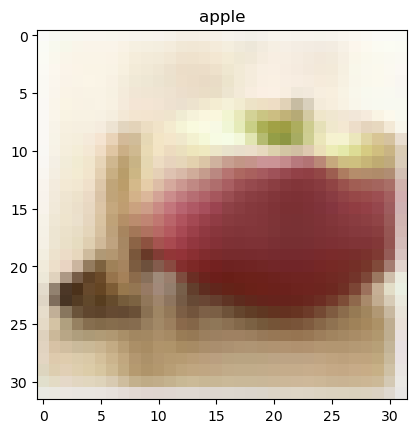

In [108]:
image = Image.fromarray(dataset.get_image(2))
# save image
image.save("data/test_image.jpeg")
plt.imshow(image)
plt.title(get_caption(image=image))
plt.show()

### Loop over each head and each cluster to generate a dictionary containing explanation for each cluster 

#### caption generation is commented, because I do it in the file make_dict.py

In [25]:
def find_matching_indexes(array, number):
    return [index for index, value in enumerate(array) if value == number]

results = {}
image_captions = {}

# loops over the head
for i, predictions_dict in enumerate(predictions_list):
    # Get prototypes
    prototype_indices = get_prototypes(config_scan, predictions_dict, features, scan)
    
    # Get number of clusters
    num_clusters  = len(prototype_indices)
    
    # Make head key 
    head_name = f"head-{num_clusters}"
    
    results[head_name] = {}
    
    # Getting the predictions for this head
    predictions_for_head = predictions_dict["predictions"]
    predictions_for_head_neighbours = predictions_dict["neighbors"]    
    
    # Loop over clusters 
    for cluster in range(num_clusters):
        
        # Set cluster key 
        cluster_name = f"cluster-{cluster}"
        
        # Find indexes of images for this cluster
        indexes_for_cluster = find_matching_indexes(predictions_for_head, cluster)
        
        images = [Image.fromarray(dataset.get_image(i)) for i in indexes_for_cluster]
        
        print(f"Cluster-{cluster}", len(indexes_for_cluster))
        # Find 20 top 
        prototype = prototype_indices[cluster]
        prototype_neighbours = predictions_for_head_neighbours[prototype]
        
        # Finds captions for top k-s in cluster
        # captions = [
        #     get_caption(image=Image.fromarray(dataset.get_image(i))) 
        #     if i not in image_captions
        #     else image_captions[i.item()]
        #     for i in prototype_neighbours
        # ]
        # for index,caption in zip(prototype_neighbours,captions):
        #     image_captions[index.item()] = caption
        
        # # Builds a key value pair with words and number of times met in captions
        # most_common_words = find_most_common_words(captions)
        # print(most_common_words)
        # # print("Center: ",prototype )
        # # print("Neighbours: ",predictions_for_head)
        # explanation = ''
        # for word, count in most_common_words[:3]:
        #     explanation = explanation + ' ' + word 
        # print(explanation)
        
        results[head_name][cluster_name] = {
            "images": images, 
            "top_neighbours": prototype_neighbours,
            "explanation": "animals"
        }
    

Get topk...
Cluster-0 9305
Cluster-1 10405
Cluster-2 9499
Cluster-3 10324
Cluster-4 10467
Get topk...
Cluster-0 2480
Cluster-1 2426
Cluster-2 2278
Cluster-3 2466
Cluster-4 2392
Cluster-5 2262
Cluster-6 3055
Cluster-7 2576
Cluster-8 2501
Cluster-9 2967
Cluster-10 2729
Cluster-11 2325
Cluster-12 2510
Cluster-13 2355
Cluster-14 2646
Cluster-15 2254
Cluster-16 2554
Cluster-17 2223
Cluster-18 2508
Cluster-19 2493
Get topk...
Cluster-0 537
Cluster-1 543
Cluster-2 492
Cluster-3 526
Cluster-4 423
Cluster-5 610
Cluster-6 537
Cluster-7 520
Cluster-8 477
Cluster-9 455
Cluster-10 450
Cluster-11 421
Cluster-12 513
Cluster-13 468
Cluster-14 535
Cluster-15 506
Cluster-16 525
Cluster-17 482
Cluster-18 452
Cluster-19 567
Cluster-20 378
Cluster-21 497
Cluster-22 568
Cluster-23 496
Cluster-24 381
Cluster-25 567
Cluster-26 352
Cluster-27 459
Cluster-28 498
Cluster-29 425
Cluster-30 426
Cluster-31 466
Cluster-32 564
Cluster-33 501
Cluster-34 506
Cluster-35 483
Cluster-36 476
Cluster-37 673
Cluster-38 573
C

#### This is how we get explanation for a cluster

In [29]:
results['head-5']["cluster-2"]["explanation"]

'animals'

### Get prediction for query Image

In [ ]:
scan.to("cpu")

### Add a query image from specified img_path

In [105]:
img_path = 'data/test_image.jpeg'

topk_sample_file_path = "results/cifar-20/pretext/topk-single_img-neighbors.npy"
indecies = np.load(topk_sample_file_path) 
img_transform = get_visualization_transformations(config_scan)
img_samples = np.array([np.asarray(Image.open(img_path))])
img_dataset = NeighborsDataset(SampleDataSet(img_samples,transform=img_transform), indecies, 20)
img_dataloader = get_val_dataloader(config_scan,img_dataset)

predictions, features = get_sample_preds(config_scan, img_dataloader, scan, return_features=True)

Files already downloaded and verified
Indecies 50001
Len: 50001


#### Each element of predictions is a cluster head and "prediction" is the cluster that it is assigned to

In [122]:
predictions[0]

{'predictions': tensor([0]),
 'probabilities': tensor([[0.6500, 0.0202, 0.2088, 0.1013, 0.0197]]),
 'targets': tensor([11]),
 'neighbors': tensor([[50000,  2980, 35606, 10462, 17562, 48960, 28464, 49322, 41462, 32247,
          31710, 14935, 12540,  3548, 36608, 15115, 12121, 33776,  4095, 10964,
          20584]])}

#### Showing test image

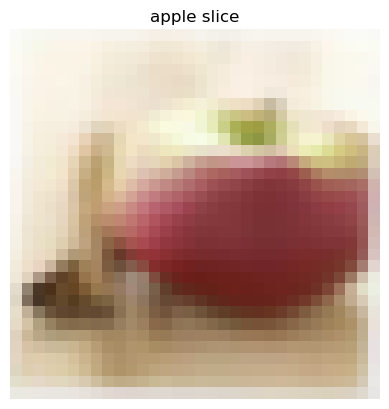

In [109]:
plt.imshow(image)
explanation = get_caption(image=image, max_new_tokens=5)
plt.title(explanation)
plt.axis("off")
plt.show()

#### Show to which cluster the image is assigned and the explation for this cluster

In [110]:

print(f"Image explanation is: {explanation}")

neighbours_per_head = {}

# loop over heads
for i, pred_for_head in enumerate(predictions):
    
    # Get cluster number of head
    head = len(pred_for_head["probabilities"][0])
    
    # Get predicted cluster
    cluster = pred_for_head["predictions"].item()
    
    # Get the explanation out of the dictionary
    cluster_explanation = results[f"head-{head}"][f"cluster-{cluster}"]["explanation"]
    
    # Get the neighbors for the query image
    neighbors = pred_for_head["neighbors"][0]
    
    # Add the query image and its neighbours to a dictionary, for each head
    neighbours_per_head[f"head-{head}"] = neighbors[:10]
    
    print(f"For classfier with {head} clusters, \
The image is classified in cluster {cluster} \
and the explanation for that cluster is :{cluster_explanation}")
    print("------------------------")

Image explanation is: apple slice
For classfier with 5 clusters, The image is classified in cluster 0 and the explanation for that cluster is animals
------------------------
For classfier with 20 clusters, The image is classified in cluster 2 and the explanation for that cluster is animals
------------------------
For classfier with 100 clusters, The image is classified in cluster 20 and the explanation for that cluster is animals
------------------------
For classfier with 300 clusters, The image is classified in cluster 271 and the explanation for that cluster is animals
------------------------
For classfier with 500 clusters, The image is classified in cluster 403 and the explanation for that cluster is animals
------------------------


### Show neighbours of the query image for a specified head

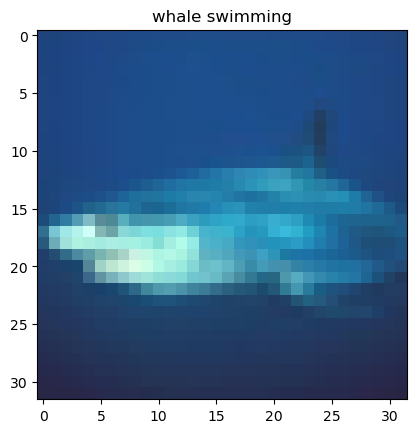

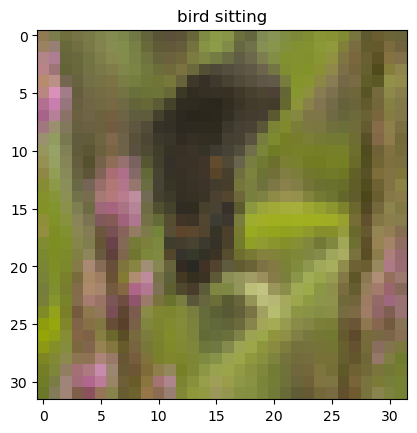

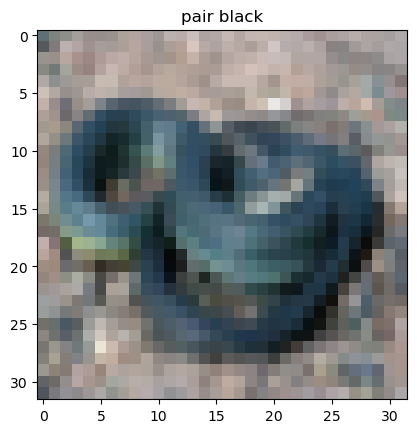

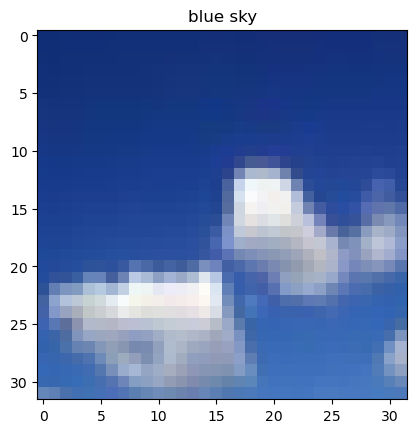

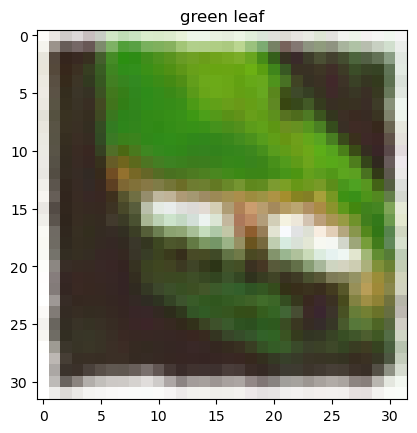

In [111]:
heads = [5, 20, 100, 300, 500]

for idx in neighbours_per_head["head-20"][:5]:
    image = Image.fromarray(dataset.get_image(idx.item() -1))
    plt.imshow(image)
    plt.title(get_caption(image=image))
    plt.show()
   

#### As you can see it does not make much sense

##### We will run this after the clusters_explanations2 is generated

In [119]:
import pickle
with open('clusters_explanations.pkl', 'rb') as handle:
    explanation_dict = pickle.load(handle)
explanation_dict.keys()

dict_keys(['head-5'])

In [120]:
explanation_dict["head-5"]["cluster-0"]["explanation"]

' swimming whale blue'